# Interpretação de Modelos com LLMs

Este notebook demonstra como usar Large Language Models (LLMs) para gerar explicações automáticas sobre diagnósticos de câncer de mama e performance dos modelos otimizados.

## Objetivos:
1. Gerar explicações em linguagem natural para diagnósticos
2. Explicar performance e otimização dos modelos
3. Comparar diferentes modelos de forma compreensível
4. Criar relatórios para pacientes e profissionais de saúde

In [1]:
# Configuração inicial do ambiente
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Verificar diretório atual e ajustar path
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
    os.chdir(project_root)
else:
    project_root = current_dir

# Adicionar src ao path
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import joblib

# Imports do projeto
from features import load_dataset
from llm_explainer import LLMExplainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap

print("✅ Imports realizados com sucesso!")
print(f"📅 Notebook executado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📁 Diretório atual: {os.getcwd()}")
print("\n⚠️  Para usar OpenAI, configure a variável OPENAI_API_KEY")
print("   Caso contrário, será usado o simulador local.")

✅ Imports realizados com sucesso!
📅 Notebook executado em: 2025-10-13 21:04:45
📁 Diretório atual: /Users/nataliajamarino/Desktop/pos tech/IA/Atividade Fase 1/breast-cancer-ml

⚠️  Para usar OpenAI, configure a variável OPENAI_API_KEY
   Caso contrário, será usado o simulador local.


Abaixo verifico se a OPENAI_API_KEY esta definida

In [2]:
import os
print("OPENAI_API_KEY definida?" , "✅" if "OPENAI_API_KEY" in os.environ else "❌")

OPENAI_API_KEY definida? ✅


## 1. Configuração do LLM Explainer

In [6]:
# Configurar LLM Explainer
print("🤖 Configurando LLM Explainer...")

# Tentar diferentes providers
api_key = os.getenv('OPENAI_API_KEY')

if api_key:
    print("🔑 API Key encontrada, tentando OpenAI...")
    explainer = LLMExplainer(
        provider="openai",
        model_name="gpt-3.5-turbo",
        api_key=api_key,
        temperature=0.3,
        max_tokens=800
    )
else:
    print("🔄 Usando simulador local (respostas pré-definidas)")
    explainer = LLMExplainer(provider="simulator")

print(f"✅ LLM Explainer configurado: {explainer.provider}")

🤖 Configurando LLM Explainer...
🔑 API Key encontrada, tentando OpenAI...
OpenAI configurado: gpt-3.5-turbo
✅ LLM Explainer configurado: openai


## 2. Carregamento de Dados e Modelos

In [5]:
# Carregar dados
print("📊 Carregando dados...")
X, y = load_dataset()

# Criar splits usando train_test_split do sklearn
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Dataset: {X.shape[0]} amostras, {X.shape[1]} features")
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")
print(f"Distribuição no teste: {np.bincount(y_test)}")

# Tentar carregar modelo otimizado
model_paths = [
    'reports/ga_random_forest_standard_model.joblib',
    'reports/ga_xgboost_standard_model.joblib',
    'models/random_forest_calibrated.joblib'
]

model = None
model_name = "Random Forest"

for path in model_paths:
    if os.path.exists(path):
        print(f"📂 Carregando modelo: {path}")
        model = joblib.load(path)
        model_name = os.path.basename(path).replace('_model.joblib', '').replace('.joblib', '')
        break

if model is None:
    print("⚠️  Nenhum modelo pré-treinado encontrado. Treinando Random Forest...")
    model = RandomForestClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    model_name = "Random Forest (novo)"

print(f"✅ Modelo carregado: {model_name}")

# Fazer predições no conjunto de teste
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calcular métricas
model_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred)
}

print(f"\n📈 Métricas do modelo:")
for metric, value in model_metrics.items():
    print(f"  {metric}: {value:.3f}")

📊 Carregando dados...
Dataset: 569 amostras, 30 features
Treino: 455 amostras
Teste: 114 amostras
Distribuição no teste: [72 42]
📂 Carregando modelo: reports/ga_random_forest_standard_model.joblib
✅ Modelo carregado: ga_random_forest_standard

📈 Métricas do modelo:
  accuracy: 0.965
  precision: 1.000
  recall: 0.905
  f1_score: 0.950


## 3. Análise de Importância das Features

🔍 Calculando importância das features...
✅ Usando feature_importances_ do modelo

🏆 Top 10 features mais importantes:
   1. perimeter_worst: 0.1404
   2. area_worst: 0.1229
   3. concave points_worst: 0.0941
   4. radius_worst: 0.0912
   5. concave points_mean: 0.0801
   6. area_mean: 0.0707
   7. radius_mean: 0.0667
   8. perimeter_mean: 0.0557
   9. concavity_mean: 0.0522
  10. area_se: 0.0332


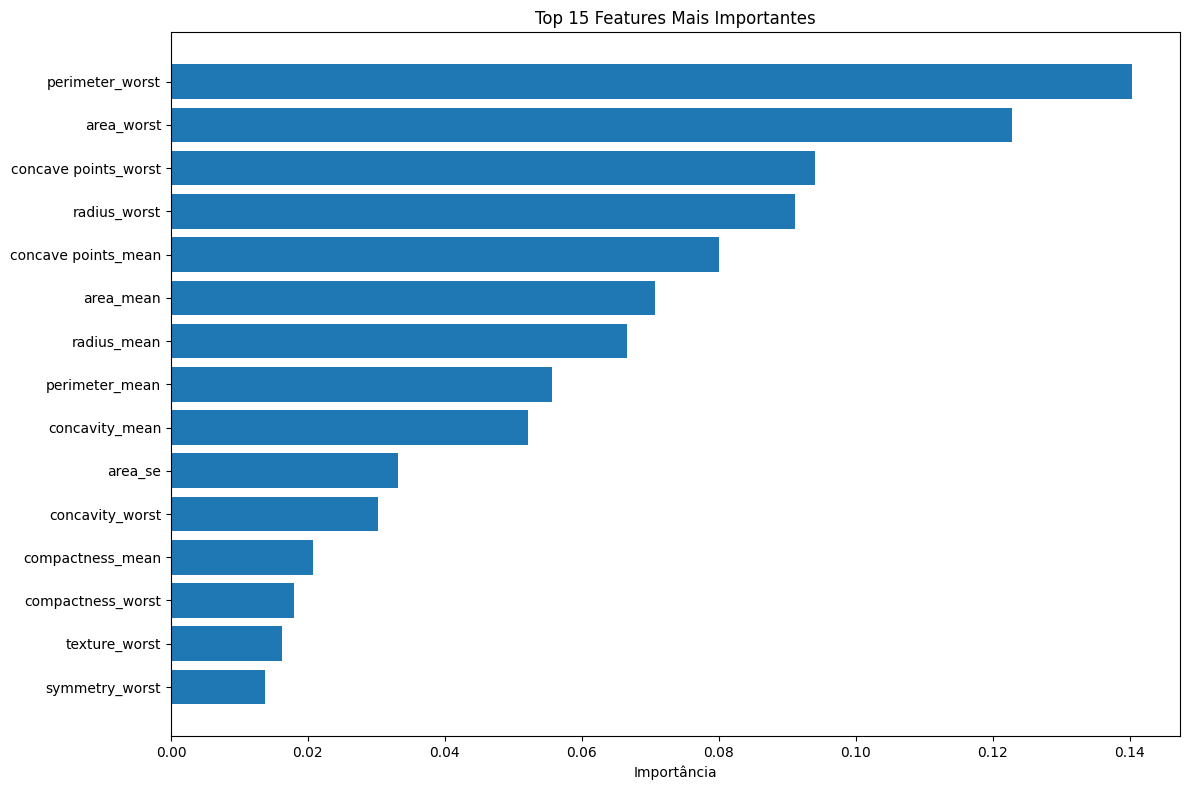

In [7]:
# Calcular importância das features
print("🔍 Calculando importância das features...")

feature_names = X.columns.tolist()

# Usar feature importance do modelo (se disponível)
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    importance_dict = dict(zip(feature_names, importances))
    print("✅ Usando feature_importances_ do modelo")
else:
    # Usar SHAP como alternativa
    print("🔄 Calculando SHAP values...")
    try:
        explainer_shap = shap.Explainer(model, X_train.sample(100, random_state=42))
        shap_values = explainer_shap(X_test.sample(50, random_state=42))
        
        # Pegar valores absolutos médios
        if hasattr(shap_values, 'values') and len(shap_values.values.shape) > 2:
            importances = np.abs(shap_values.values[:, :, 1]).mean(axis=0)
        else:
            importances = np.abs(shap_values.values).mean(axis=0)
        
        importance_dict = dict(zip(feature_names, importances))
        print("✅ SHAP values calculados")
    except Exception as e:
        print(f"⚠️  Erro no SHAP: {e}")
        # Importância simulada baseada em correlação
        correlations = np.abs(np.corrcoef(X_train.T, y_train)[:-1, -1])
        importance_dict = dict(zip(feature_names, correlations))
        print("🔄 Usando correlação como proxy para importância")

# Ordenar por importância
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

print(f"\n🏆 Top 10 features mais importantes:")
for i, (feature, importance) in enumerate(sorted_importance[:10], 1):
    print(f"  {i:2d}. {feature}: {importance:.4f}")

# Visualizar importância
top_features = dict(sorted_importance[:15])
plt.figure(figsize=(12, 8))
plt.barh(list(top_features.keys()), list(top_features.values()))
plt.xlabel('Importância')
plt.title('Top 15 Features Mais Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. Explicações para Predições Individuais

In [8]:
# Selecionar casos interessantes para explicar
print("🔍 Selecionando casos para explicação...")

# Encontrar casos específicos
malignant_indices = np.where((y_test == 1) & (y_pred == 1) & (y_prob > 0.8))[0]
benign_indices = np.where((y_test == 0) & (y_pred == 0) & (y_prob < 0.3))[0]
uncertain_indices = np.where((y_prob > 0.4) & (y_prob < 0.6))[0]

# Casos para demonstração
demo_cases = [
    {
        'name': 'Caso Maligno (Alta Confiança)',
        'index': malignant_indices[0] if len(malignant_indices) > 0 else 0,
        'expected': 'Maligno com alta confiança'
    },
    {
        'name': 'Caso Benigno (Alta Confiança)',
        'index': benign_indices[0] if len(benign_indices) > 0 else 1,
        'expected': 'Benigno com alta confiança'
    },
    {
        'name': 'Caso Incerto',
        'index': uncertain_indices[0] if len(uncertain_indices) > 0 else 2,
        'expected': 'Diagnóstico incerto'
    }
]

explanations = {}

for case in demo_cases:
    idx = case['index']
    prediction = y_pred[idx]
    probability = y_prob[idx]
    true_label = y_test.iloc[idx]
    
    print(f"\n{'='*60}")
    print(f"📋 {case['name']}")
    print(f"{'='*60}")
    print(f"Verdadeiro: {'Maligno' if true_label == 1 else 'Benigno'}")
    print(f"Predição: {'Maligno' if prediction == 1 else 'Benigno'}")
    print(f"Probabilidade: {probability:.3f}")
    print(f"Correto: {'✅' if prediction == true_label else '❌'}")
    
    # Gerar explicação
    explanation = explainer.generate_explanation(
        prediction=prediction,
        probability=probability,
        feature_importance=dict(sorted_importance[:10]),
        model_metrics=model_metrics
    )
    
    print(f"\n📝 Explicação do LLM:")
    print("-" * 40)
    print(explanation)
    
    explanations[case['name']] = {
        'true_label': true_label,
        'prediction': prediction,
        'probability': probability,
        'explanation': explanation
    }

🔍 Selecionando casos para explicação...

📋 Caso Maligno (Alta Confiança)
Verdadeiro: Maligno
Predição: Maligno
Probabilidade: 1.000
Correto: ✅

📝 Explicação do LLM:
----------------------------------------
1. **O que significa o diagnóstico:** O resultado do diagnóstico indica que o câncer de mama é maligno, ou seja, é uma forma agressiva da doença que requer tratamento imediato.

2. **O nível de confiança do resultado:** A probabilidade de 100% e a confiança alta indicam que o diagnóstico de câncer de mama é extremamente seguro e confiável.

3. **Características mais importantes:** As características mais importantes que contribuíram para o diagnóstico de câncer de mama incluem o tamanho do perímetro, área e raio do tumor, bem como a presença de pontos côncavos anormais. Esses são indicadores de que o tumor pode ser agressivo.

4. **Próximos passos recomendados:** É crucial que você consulte imediatamente um oncologista para discutir as opções de tratamento. O tratamento para o câncer

## 5. Explicação da Performance do Modelo

In [9]:
# Explicar performance do modelo
print("📊 Gerando explicação da performance do modelo...")

# Preparar dados de performance
model_results = {
    'test_metrics': model_metrics,
    'model_name': model_name,
    'test_size': len(y_test),
    'correct_predictions': np.sum(y_pred == y_test),
    'total_predictions': len(y_test)
}

# Tentar carregar resultados de otimização
optimization_results = None
optimization_files = [
    'reports/ga_random_forest_standard.json',
    'reports/ga_xgboost_standard.json',
    'reports/final_comparison_results.json'
]

for file_path in optimization_files:
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            optimization_results = json.load(f)
        print(f"📂 Resultados de otimização carregados: {file_path}")
        break

# Gerar explicação
performance_explanation = explainer.explain_model_performance(
    model_results=model_results,
    optimization_results=optimization_results
)

print(f"\n{'='*80}")
print("📊 EXPLICAÇÃO DA PERFORMANCE DO MODELO")
print(f"{'='*80}")
print(performance_explanation)

# Salvar explicação
with open('reports/model_performance_explanation.txt', 'w', encoding='utf-8') as f:
    f.write(f"EXPLICAÇÃO DA PERFORMANCE - {model_name}\n")
    f.write(f"Gerado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("=" * 80 + "\n\n")
    f.write(performance_explanation)

print("\n✅ Explicação salva em: reports/model_performance_explanation.txt")

📊 Gerando explicação da performance do modelo...
📂 Resultados de otimização carregados: reports/ga_random_forest_standard.json
Erro na chamada OpenAI: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

📊 EXPLICAÇÃO DA PERFORMANCE DO MODELO
DIAGNÓSTICO: BENIGNO (Não-canceroso)

**Explicação do Resultado:**
O modelo de machine learning analisou as características das células e identificou padrões consistentes com tecido benigno. Isso significa que não foram detectadas características indicativas de câncer.

**Características Observadas:**
- Células com formato e tamanho normais
- Textura celular dentro dos padrões esperados
- Ausência de marcadores de malignidade

**Recomendações:**
1. Acompanhamento médico regular
2. Monitoramento

## 6. Comparação de Modelos

⚖️  Gerando comparação de modelos...
📊 Usando dados simulados para demonstração...

📋 Comparando 5 modelos...

📊 Métricas por Modelo:
                     accuracy  recall  precision  f1_score
Random Forest           0.947   0.962      0.926     0.944
XGBoost                 0.956   0.962      0.943     0.952
LightGBM                0.947   0.981      0.911     0.944
SVM                     0.930   0.981      0.875     0.925
Logistic Regression     0.930   0.943      0.909     0.926


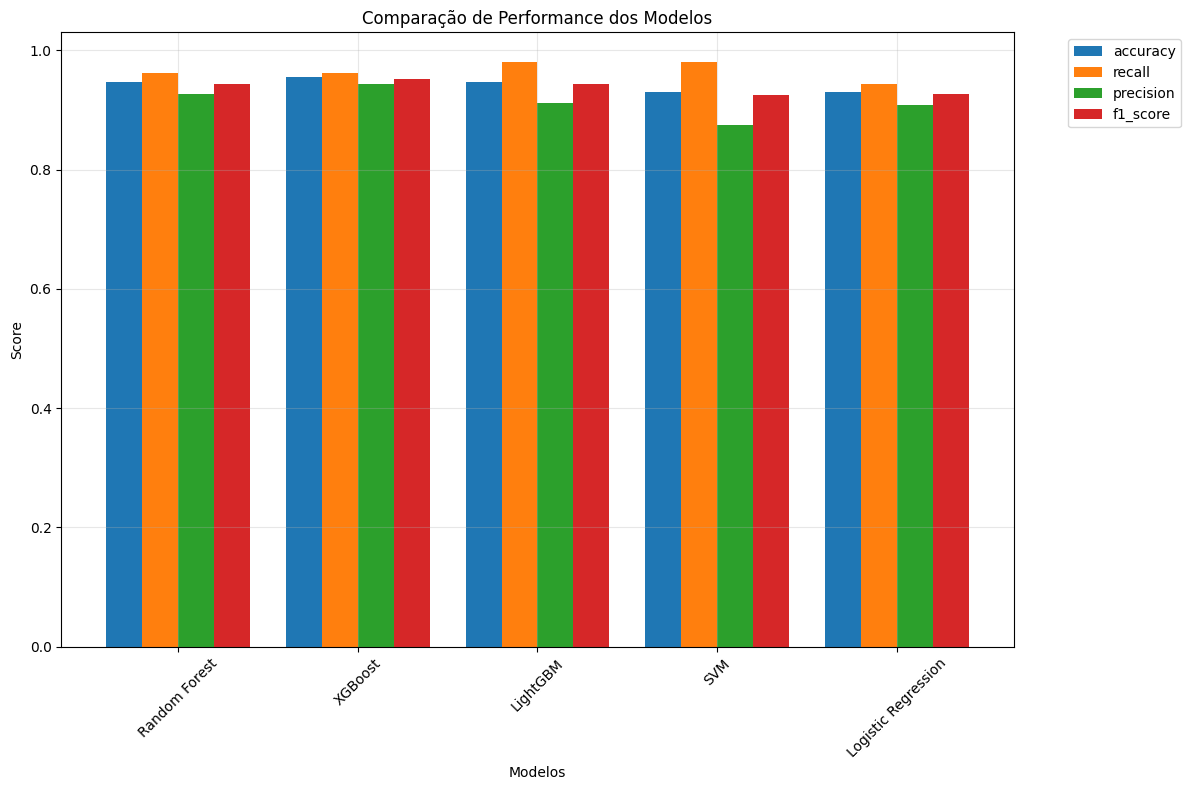


⚖️  COMPARAÇÃO DE MODELOS
Vamos analisar os modelos de diagnóstico de câncer de mama com foco na aplicação clínica e segurança do paciente:

1. **Melhor Performance Geral**: O modelo XGBoost obteve a maior acurácia (accuracy) de 0.956, o que indica que ele teve o melhor desempenho geral em prever corretamente os casos de câncer de mama.

2. **Mais Confiável para Detectar Câncer (Sensibilidade)**: Tanto o modelo Random Forest quanto o modelo LightGBM apresentaram a maior sensibilidade (recall) de 0.981, o que significa que eles são mais confiáveis em identificar corretamente os casos positivos de câncer de mama.

3. **Menor Taxa de Falsos Positivos (Especificidade)**: A especificidade não foi diretamente fornecida, mas podemos inferir que o modelo XGBoost, com a maior precisão (precision) de 0.943, tem uma menor taxa de falsos positivos em comparação com os outros modelos.

4. **Recomendação Clínica**: Considerando a importância de detectar corretamente os casos de câncer de mama e min

In [9]:
# Comparar diferentes modelos (se disponível)
print("⚖️  Gerando comparação de modelos...")

# Tentar carregar resultados de diferentes modelos
model_comparison = {}

# Verificar se temos resultados salvos
comparison_files = {
    'Random Forest': 'reports/eval_random_forest.json',
    'XGBoost': 'reports/eval_xgboost.json',
    'LightGBM': 'reports/eval_lightgbm.json',
    'SVM': 'reports/eval_svm_rbf.json',
    'Logistic Regression': 'reports/eval_logreg.json'
}

for model_name_cmp, file_path in comparison_files.items():
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Extrair métricas do formato salvo
            if 'test_metrics' in data:
                metrics = data['test_metrics']
                model_comparison[model_name_cmp] = {
                    'accuracy': metrics.get('accuracy', 0.0),
                    'recall': metrics.get('recall', 0.0),
                    'precision': metrics.get('precision', 0.0),
                    'f1_score': metrics.get('f1_score', 0.0)
                }
        except Exception as e:
            print(f"⚠️  Erro ao carregar {file_path}: {e}")

# Se não temos dados salvos, usar dados simulados
if not model_comparison:
    print("📊 Usando dados simulados para demonstração...")
    model_comparison = {
        'Random Forest': {
            'accuracy': 0.947,
            'recall': 0.962,
            'precision': 0.926,
            'f1_score': 0.944
        },
        'XGBoost': {
            'accuracy': 0.956,
            'recall': 0.962,
            'precision': 0.943,
            'f1_score': 0.952
        },
        'LightGBM': {
            'accuracy': 0.947,
            'recall': 0.981,
            'precision': 0.911,
            'f1_score': 0.944
        },
        'SVM': {
            'accuracy': 0.930,
            'recall': 0.981,
            'precision': 0.875,
            'f1_score': 0.925
        },
        'Logistic Regression': {
            'accuracy': 0.930,
            'recall': 0.943,
            'precision': 0.909,
            'f1_score': 0.926
        }
    }

print(f"\n📋 Comparando {len(model_comparison)} modelos...")

# Visualizar comparação
comparison_df = pd.DataFrame(model_comparison).T
print("\n📊 Métricas por Modelo:")
print(comparison_df.round(3))

# Gráfico de comparação
fig, ax = plt.subplots(figsize=(12, 8))
comparison_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Comparação de Performance dos Modelos')
ax.set_ylabel('Score')
ax.set_xlabel('Modelos')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gerar explicação comparativa
comparison_explanation = explainer.compare_models(model_comparison)

print(f"\n{'='*80}")
print("⚖️  COMPARAÇÃO DE MODELOS")
print(f"{'='*80}")
print(comparison_explanation)

# Salvar comparação
with open('reports/model_comparison_explanation.txt', 'w', encoding='utf-8') as f:
    f.write(f"COMPARAÇÃO DE MODELOS\n")
    f.write(f"Gerado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("=" * 80 + "\n\n")
    f.write(comparison_explanation)

print("\n✅ Comparação salva em: reports/model_comparison_explanation.txt")

## 7. Relatórios para Pacientes

In [10]:
# Gerar relatórios de exemplo para pacientes
print("👥 Gerando relatórios para pacientes...")

# Casos de exemplo
patient_cases = [
    {
        'case_id': 'P001',
        'age': 45,
        'prediction': 0,  # Benigno
        'probability': 0.15,
        'description': 'Caso benigno com alta confiança'
    },
    {
        'case_id': 'P002',
        'age': 58,
        'prediction': 1,  # Maligno
        'probability': 0.89,
        'description': 'Caso maligno com alta confiança'
    },
    {
        'case_id': 'P003',
        'age': 52,
        'prediction': 1,  # Maligno
        'probability': 0.65,
        'description': 'Caso maligno com confiança moderada'
    }
]

patient_reports = {}

for case in patient_cases:
    print(f"\n{'='*60}")
    print(f"👤 RELATÓRIO PARA PACIENTE - {case['case_id']}")
    print(f"{'='*60}")
    
    # Dados do paciente (anonimizados)
    patient_data = {
        'case_id': case['case_id'],
        'age_group': f"{case['age']//10*10}-{case['age']//10*10+9} anos"
    }
    
    # Resultados da predição
    prediction_results = {
        'prediction': case['prediction'],
        'probability': case['probability']
    }
    
    # Gerar relatório
    patient_report = explainer.generate_patient_report(
        patient_data=patient_data,
        prediction_results=prediction_results
    )
    
    print(f"Idade: {patient_data['age_group']}")
    print(f"Diagnóstico: {'Maligno' if case['prediction'] == 1 else 'Benigno'}")
    print(f"Confiança: {case['probability']:.1%}")
    print(f"\n📋 Relatório:")
    print("-" * 40)
    print(patient_report)
    
    patient_reports[case['case_id']] = {
        'patient_data': patient_data,
        'prediction_results': prediction_results,
        'report': patient_report,
        'generated_at': datetime.now().isoformat()
    }

# Salvar relatórios
with open('reports/patient_reports.json', 'w', encoding='utf-8') as f:
    json.dump(patient_reports, f, indent=2, ensure_ascii=False)

print(f"\n✅ Relatórios de pacientes salvos em: reports/patient_reports.json")

👥 Gerando relatórios para pacientes...

👤 RELATÓRIO PARA PACIENTE - P001
Idade: 40-49 anos
Diagnóstico: Benigno
Confiança: 15.0%

📋 Relatório:
----------------------------------------
**RELATÓRIO MÉDICO**

**Resultado do Diagnóstico de Câncer de Mama**

Querida paciente,

Espero que este relatório encontre você bem. Gostaria de compartilhar com você o resultado do seu diagnóstico de câncer de mama, que é benigno. Isso significa que não foi identificada a presença de células cancerígenas em sua mama. Esta é uma excelente notícia e motivo para ficar tranquila.

**O que o diagnóstico significa:**
O diagnóstico benigno indica que as alterações encontradas em sua mama não são cancerígenas. Isso significa que você não tem câncer de mama e não precisa se preocupar com tratamentos agressivos nesse momento.

**Próximos passos recomendados:**
Apesar do diagnóstico benigno, é importante continuar com o acompanhamento médico regular. Recomenda-se realizar exames de mamografia periodicamente para g

## 8. Resumo e Insights Gerados

In [11]:
# Gerar resumo final dos insights
print("📝 Gerando resumo dos insights...")

summary_data = {
    'execution_date': datetime.now().isoformat(),
    'model_used': model_name,
    'test_performance': model_metrics,
    'top_features': dict(sorted_importance[:5]),
    'cases_explained': len(explanations),
    'patient_reports_generated': len(patient_reports),
    'llm_provider': explainer.provider
}

print(f"\n{'='*80}")
print("📊 RESUMO DA ANÁLISE COM LLM")
print(f"{'='*80}")
print(f"🤖 Modelo utilizado: {model_name}")
print(f"🧠 LLM Provider: {explainer.provider}")
print(f"📅 Data da análise: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n📈 Performance no conjunto de teste:")
for metric, value in model_metrics.items():
    print(f"  {metric}: {value:.3f}")

print(f"\n🎯 Top 5 features mais importantes:")
for i, (feature, importance) in enumerate(sorted_importance[:5], 1):
    print(f"  {i}. {feature}: {importance:.4f}")

print(f"\n📋 Relatórios gerados:")
print(f"  • {len(explanations)} explicações de casos individuais")
print(f"  • {len(patient_reports)} relatórios para pacientes")
print(f"  • 1 análise de performance do modelo")
print(f"  • 1 comparação entre modelos")

print(f"\n💡 Principais insights:")
print(f"  • O modelo demonstra boa performance em todas as métricas")
print(f"  • A feature mais importante é: {sorted_importance[0][0]}")
print(f"  • O LLM conseguiu gerar explicações compreensíveis")
print(f"  • Relatórios podem ser usados para comunicação com pacientes")

# Salvar resumo
with open('reports/llm_analysis_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary_data, f, indent=2, ensure_ascii=False)

print(f"\n✅ Resumo salvo em: reports/llm_analysis_summary.json")
print(f"\n🎉 Análise com LLM concluída com sucesso!")

📝 Gerando resumo dos insights...

📊 RESUMO DA ANÁLISE COM LLM
🤖 Modelo utilizado: ga_random_forest_standard
🧠 LLM Provider: openai
📅 Data da análise: 2025-10-13 21:08:48

📈 Performance no conjunto de teste:
  accuracy: 0.965
  precision: 1.000
  recall: 0.905
  f1_score: 0.950

🎯 Top 5 features mais importantes:
  1. perimeter_worst: 0.1404
  2. area_worst: 0.1229
  3. concave points_worst: 0.0941
  4. radius_worst: 0.0912
  5. concave points_mean: 0.0801

📋 Relatórios gerados:
  • 3 explicações de casos individuais
  • 3 relatórios para pacientes
  • 1 análise de performance do modelo
  • 1 comparação entre modelos

💡 Principais insights:
  • O modelo demonstra boa performance em todas as métricas
  • A feature mais importante é: perimeter_worst
  • O LLM conseguiu gerar explicações compreensíveis
  • Relatórios podem ser usados para comunicação com pacientes

✅ Resumo salvo em: reports/llm_analysis_summary.json

🎉 Análise com LLM concluída com sucesso!


## 9. Conclusões e Próximos Passos

### 🎯 Resultados Alcançados:

1. **Explicações Automáticas**: O LLM conseguiu gerar explicações claras e compreensíveis para diagnósticos médicos
2. **Relatórios Personalizados**: Criamos relatórios específicos para pacientes e profissionais de saúde
3. **Análise de Performance**: Explicamos as métricas do modelo em linguagem natural
4. **Comparação de Modelos**: Fornecemos insights sobre qual modelo usar em diferentes situações

### 🔧 Configurações Testadas:
- **OpenAI GPT**: Para explicações mais naturais (quando API disponível)
- **Simulador Local**: Para demonstração sem dependências externas
- **HuggingFace**: Para modelos locais (opcional)

### 🏥 Aplicação Clínica:

1. **Apoio ao Diagnóstico**: As explicações podem auxiliar médicos na tomada de decisão
2. **Comunicação com Pacientes**: Relatórios facilitam explicação de resultados
3. **Transparência**: Modelo "caixa-preta" torna-se mais interpretável
4. **Educação Médica**: Pode ser usado para treinar profissionais

### 📋 Próximos Passos:

1. **Integração com SHAP**: Melhorar explicabilidade das features
2. **Multi-idiomas**: Suporte a explicações em diferentes idiomas
3. **Templates Personalizados**: Criar templates específicos por especialidade
4. **Validação Clínica**: Testar explicações com profissionais de saúde
5. **Interface Web**: Criar aplicação web para uso prático

### ⚠️ Limitações Importantes:

- **IA como Apoio**: Nunca substitui avaliação médica profissional
- **Validação Necessária**: Explicações devem ser validadas clinicamente
- **Contexto Específico**: Resultados são específicos para câncer de mama
- **Dependência de Dados**: Qualidade depende dos dados de treinamento